In [3025]:
import warnings
import os
import urllib3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder

from sklearn.utils import check_array
from scipy import sparse

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectFromModel

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict

from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score, roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix

%matplotlib inline
warnings.filterwarnings("always")

In [3026]:
DATASETS_DIRECTORY = os.path.join(os.getcwd(), "datasets")

train_data = pd.read_csv(os.path.join(DATASETS_DIRECTORY, "train.csv"))
test_data = pd.read_csv(os.path.join(DATASETS_DIRECTORY, "test.csv"))
full_data = pd.concat([train_data,test_data])

# Create targets and drop them from train data
targets = train_data["Survived"]
train_data.drop("Survived", axis=1, inplace=True)


In [3027]:
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3028]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# A class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)
    

# Custom transformers for Titanic Dataset

class CreateFamilySize(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        FamilySize = X['Parch'] + X['SibSp'] + 1
        # introducing other features based on the family size
        Familytype = FamilySize.map(lambda s: "Single" if s == 1 else ("Small" if 2 <= s <= 4 else "Large"))
        New_Df = pd.DataFrame(data=Familytype, columns=["Familytype"])
        return New_Df

class FillMissingCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        New_Df = X.copy()
        New_Df.fillna("U", inplace=True)
        
        return pd.DataFrame(data=New_Df["Cabin"], columns=["Cabin"])
    
class ExtractCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        New_Df = X.copy()
        New_Df["Cabin"] = New_Df.Cabin.apply(lambda x: x[0])
        New_Df["Cabin"] = New_Df["Cabin"].str.replace("T", "U")
        New_Df["Cabin"] = New_Df["Cabin"].str.replace("F", "U")
        New_Df["Cabin"] = New_Df["Cabin"].str.replace("G", "U")
        
        return pd.DataFrame(data=New_Df["Cabin"], columns=["Cabin"])

class HasCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        New_Df = X.copy()
        New_Df["Has_Cabin"] = [0 if pd.isnull(x) else 1 for x in New_Df["Cabin"]]
        
        return pd.DataFrame(data=New_Df["Has_Cabin"], columns=["Has_Cabin"])
    
class ExtractTitle(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        Title_Dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir" : "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess":"Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr" : "Mr",
            "Mrs" : "Mrs",
            "Miss" : "Miss",
            "Master" : "Royalty",
            "Lady" : "Royalty"
        }
        
        New_Df = X.copy()
        New_Df["Title"] = New_Df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
        New_Df["Title"] = New_Df.Title.map(Title_Dictionary)
        New_Df.fillna("Mrs", inplace=True)
        return pd.DataFrame(data=New_Df["Title"], columns=["Title"])
    


In [3029]:
# full pipeline for data engineering

full_pipeline = Pipeline(steps=[
    ("features", make_union(
        make_pipeline(DataFrameSelector(["Embarked"]), MostFrequentImputer(), CategoricalEncoder(encoding='onehot-dense')),
        make_pipeline(DataFrameSelector(["Pclass", "Sex"]), CategoricalEncoder(encoding='onehot-dense')),
        make_pipeline(DataFrameSelector(["Age", "Fare"]), Imputer(strategy="median"), StandardScaler()),
        make_pipeline(DataFrameSelector(["Name"]), ExtractTitle(), CategoricalEncoder(encoding='onehot-dense')),
        #make_pipeline(DataFrameSelector(["Cabin"]), FillMissingCabin(), ExtractCabin(), CategoricalEncoder(encoding='onehot-dense')),
        make_pipeline(DataFrameSelector(["Cabin"]), HasCabin()),
        make_pipeline(DataFrameSelector(["SibSp", "Parch"]), CreateFamilySize(), CategoricalEncoder(encoding='onehot-dense')), 
        #DataFrameSelector(["SibSp", "Parch"])
    )),
    ("poly", PolynomialFeatures()),
    #("PCA", PCA(n_components=0.95)),
    #("best", SelectKBest(k=20)),
    ("clf", RandomForestClassifier(random_state=42))
])


In [3030]:
X_train, X_test, y_train, y_test = train_test_split(train_data, targets, test_size=0.2, random_state=42)

In [3031]:
param_grid = [
    {        
        #'clf__bootstrap': [True],
        #'clf__max_depth': [80, 90, 100, 110],
        #'clf__max_features': [2, 3],
        #'clf__min_samples_leaf': [3, 4, 5],
        #'clf__min_samples_split': [8, 10, 12],
        #'clf__n_estimators': [100, 200, 300, 1000]
        'clf__bootstrap':[True], 
        'clf__max_depth':[80], 
        'clf__max_features':[2], 
        'clf__min_samples_leaf':[4], 
        'clf__min_samples_split':[10],
        'clf__n_estimators':[100]
    },
]

#scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# create the GridSearchCV object
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='roc_auc', refit=True) #verbose=3 

# fine-tune the hyperparameters
grid_search.fit(X_train, y_train)

# get the best model
final_model = grid_search.best_estimator_

# predict using the test dataset
test_predictions = final_model.predict(X_test)

accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
auc_roc = roc_auc_score(y_test, test_predictions)

print("accuracy_score = {a}, precision_score = {b}, recall_score = {c}, f1_score = {d}, AUC ROC = {e}"
      .format(a=accuracy, b=precision, c=recall, d=f1, e=auc_roc))

accuracy_score = 0.8100558659217877, precision_score = 0.8125, recall_score = 0.7027027027027027, f1_score = 0.7536231884057971, AUC ROC = 0.7942084942084942


In [3032]:
y_scores = cross_val_predict(final_model, X_test, y_test, cv=5, method="predict_proba")

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])

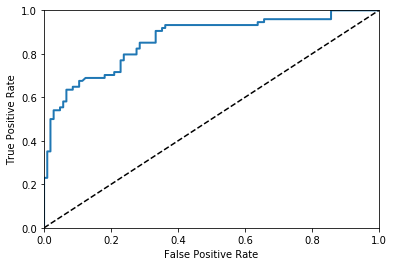

In [3033]:
def plot_roc_curve( fpr, tpr, label = None): 
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([ 0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

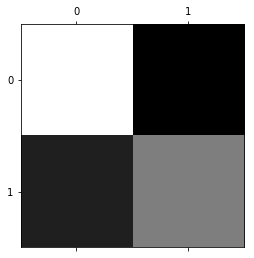

In [3034]:
conf_mx = confusion_matrix(y_test, test_predictions)

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [3035]:
print('Best accuracy: %.3f' % grid_search.best_score_)

Best accuracy: 0.858


In [3036]:
final_predictions = final_model.predict(test_data)
final_predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [3037]:
output = pd.DataFrame({ 'PassengerId' : test_data["PassengerId"], 'Survived': final_predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
